In [1]:
# Read file which has format:
# {"params": "{'ds': 'two-circles', 'n': 1000, 'eps': 0.2, 'k': 2}", "result": {"gen_time": 0.0011019706726074219, "coreset_time": 3.4044859409332275, "coreset_size": 1000, "kmeans_time": 0.0034589767456054688, "kmeans_rounds": 24, "precision": 0.998, "recall": 0.997996000016032, "fmeasure": 0.997998000004008, "rand": 0.998, "jaccard": 0.996004}}

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Each line is stored as:
# file.write(f"{params}: {result}\n")

df = pd.read_csv("results.csv", sep=",")
    
df.head()

,run_id,algorithm,stochasticity,discount_factor,learning_rate,epsilon,episode_length_mc,grid_name,reward_function,cumulative_reward,step,episode
0,a6a54126-a20c-4226-b1a5-e420c88c95fc,Value Iteration,0.0,0.9,-1.0,-1.0,-1,grid_configs/A1_grid.npy,Default,10,0,0
1,a6a54126-a20c-4226-b1a5-e420c88c95fc,Value Iteration,0.0,0.9,-1.0,-1.0,-1,grid_configs/A1_grid.npy,Default,-4996,16,16
2,ab6a7db1-493c-46e6-afe7-a8a3ed7bc6e4,Value Iteration,0.1,0.9,-1.0,-1.0,-1,grid_configs/A1_grid.npy,Default,-1,0,0
3,ab6a7db1-493c-46e6-afe7-a8a3ed7bc6e4,Value Iteration,0.1,0.9,-1.0,-1.0,-1,grid_configs/A1_grid.npy,Default,-4676,18,18
4,fa752c4a-8fe2-4112-8c6c-6c041e97c9d9,Value Iteration,0.3,0.9,-1.0,-1.0,-1,grid_configs/A1_grid.npy,Default,-1112,0,0


/var/folders/76/dl3rv17s7xz76wgx74llyccm0000gn/T/ipykernel_12464/1774447855.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


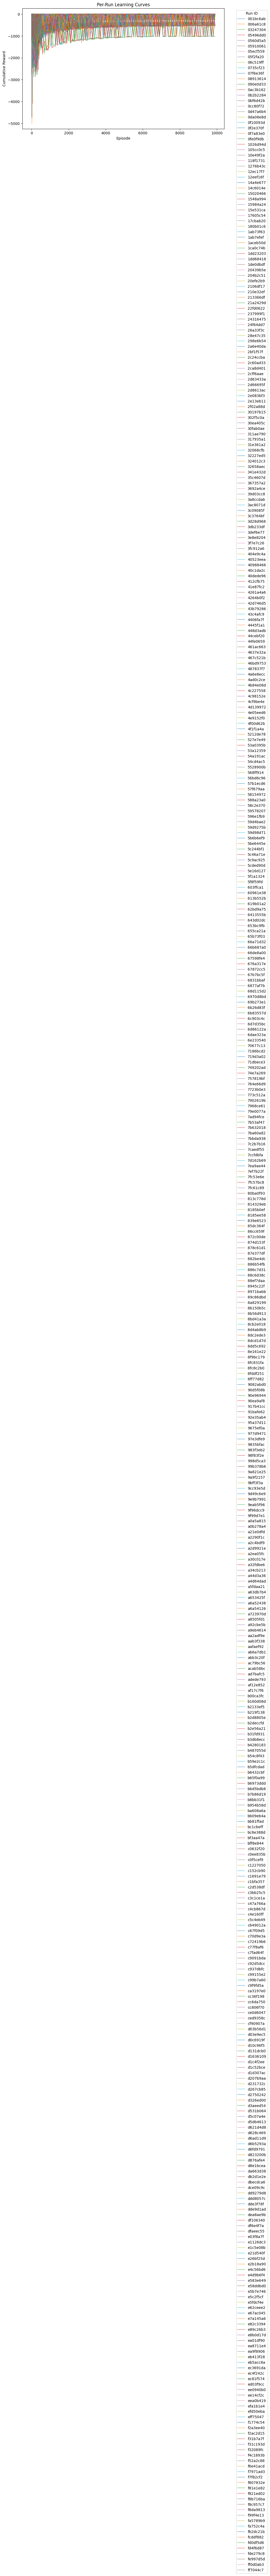

In [2]:
# Graph generated using ChatGPT:
# https://chatgpt.com/share/681dc499-9e24-8001-93b2-1d11e7a01f58

# 2) Plot each run_id as a separate line
plt.figure(figsize=(10, 6))
for run_id, run_df in df.groupby('run_id'):
    plt.plot(
        run_df['episode'],
        run_df['cumulative_reward'],
        label=str(run_id)[:8],  # truncate for readability
        alpha=0.5
    )
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Per-Run Learning Curves')
plt.legend(title='Run ID', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


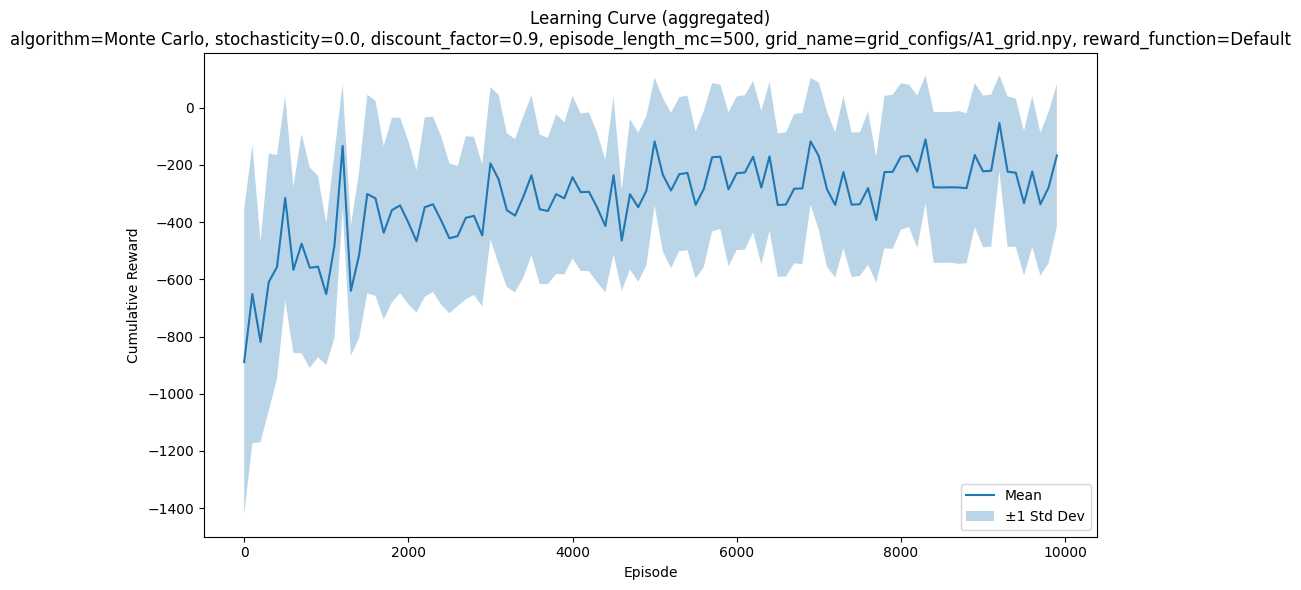

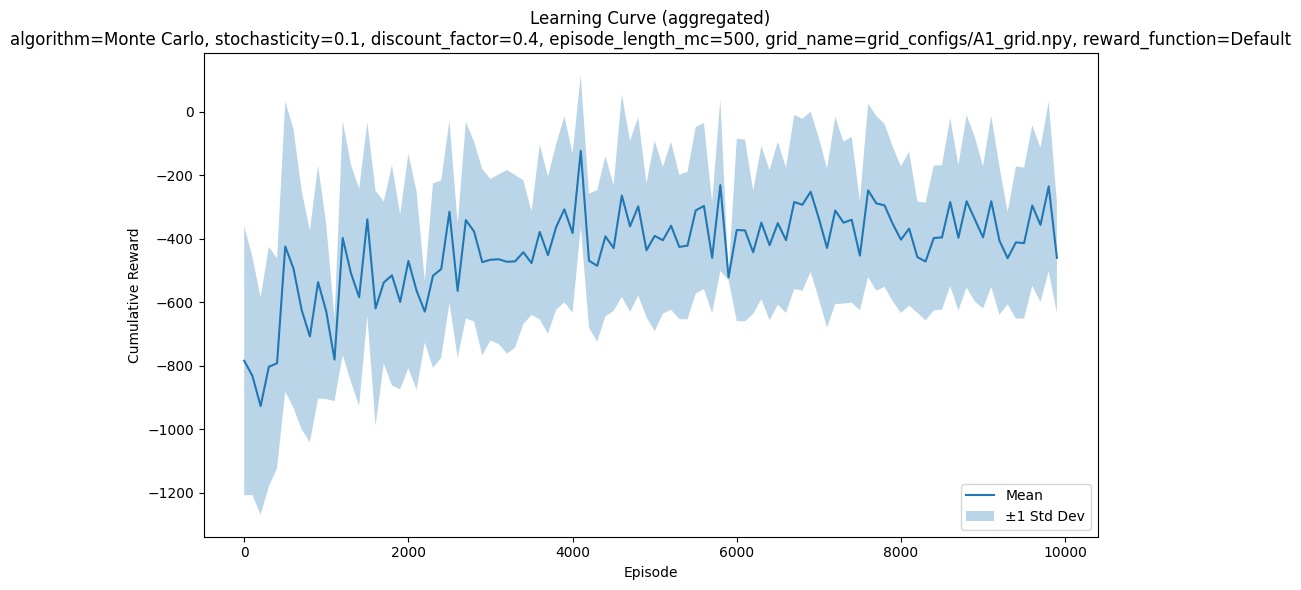

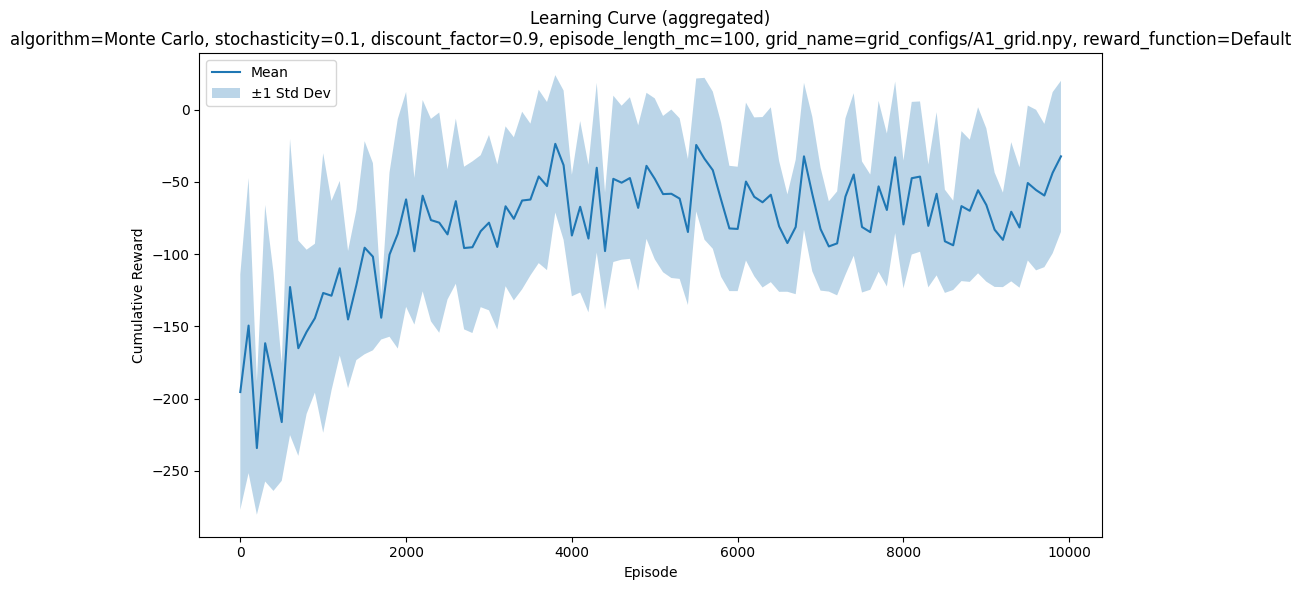

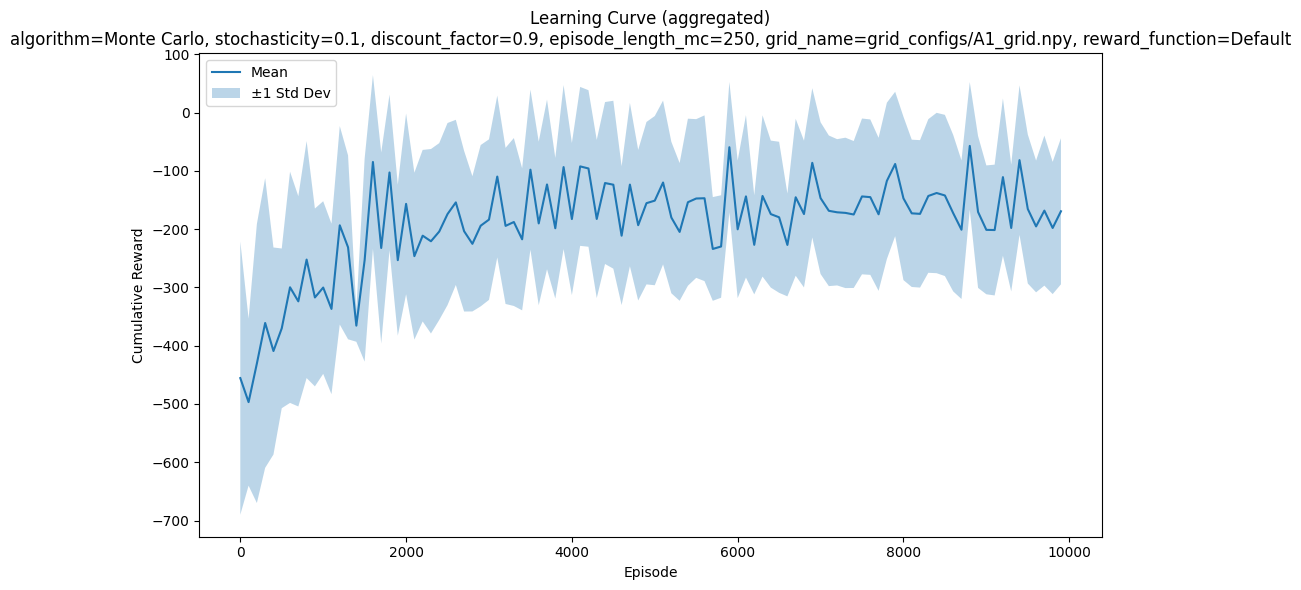

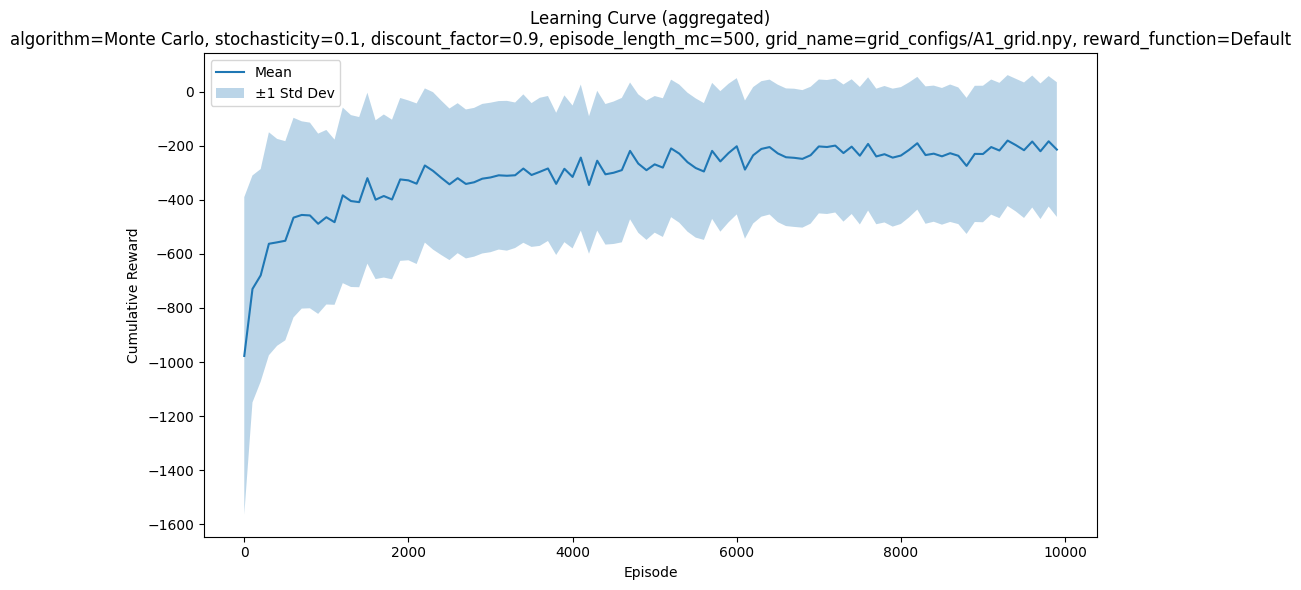

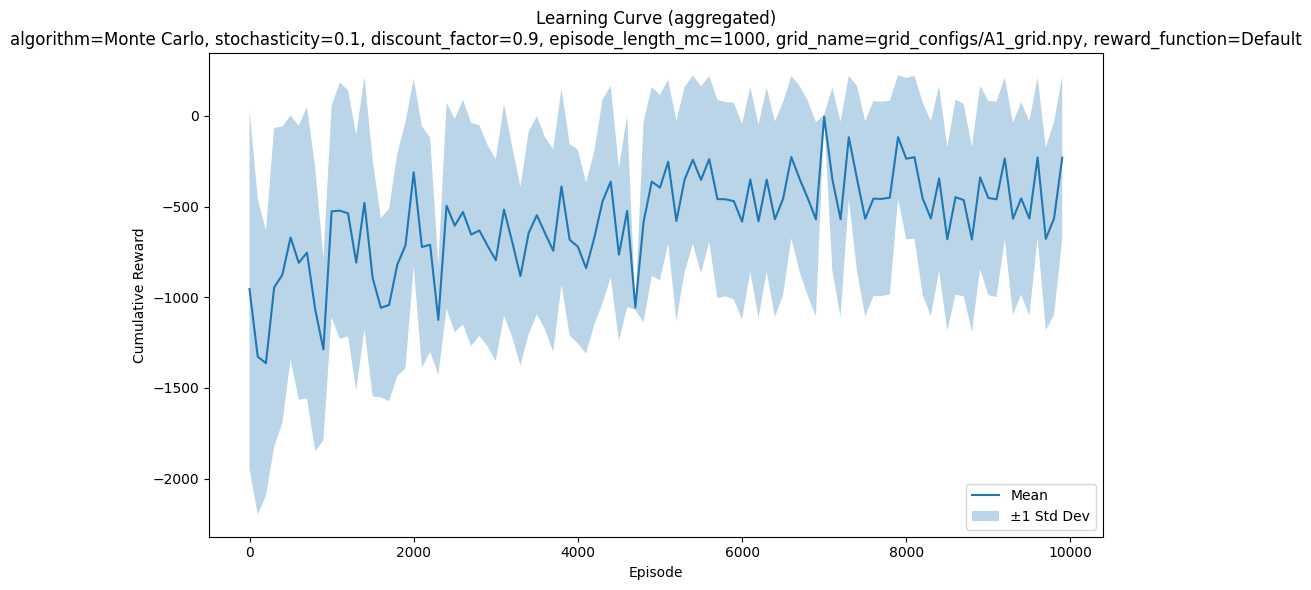

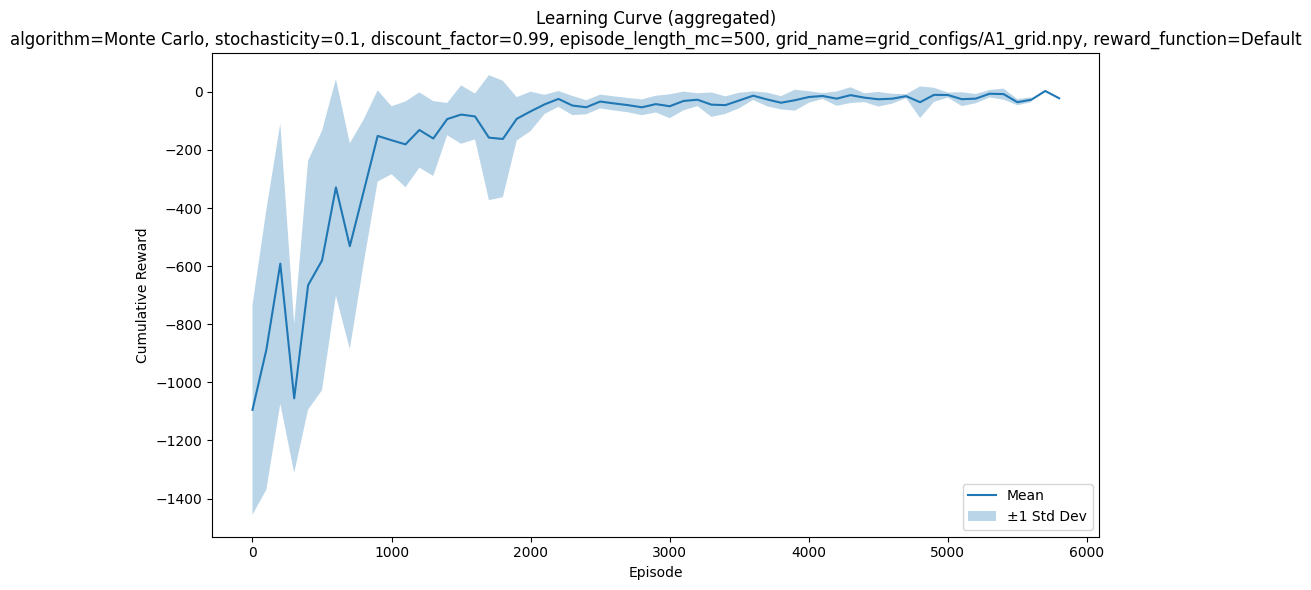

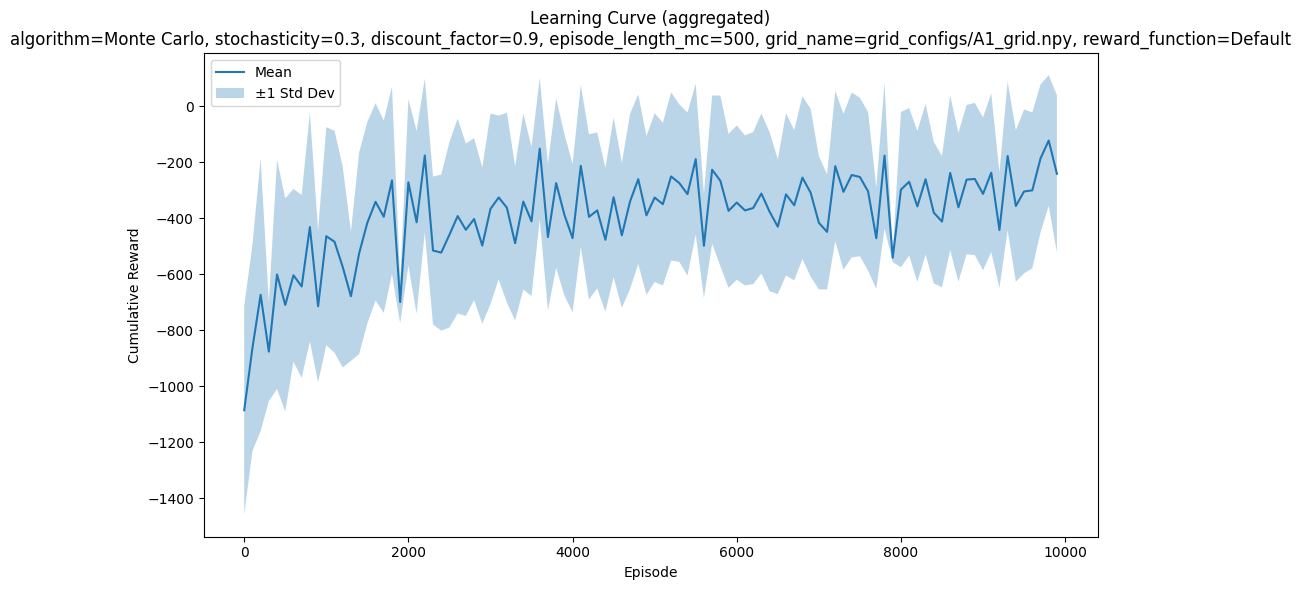

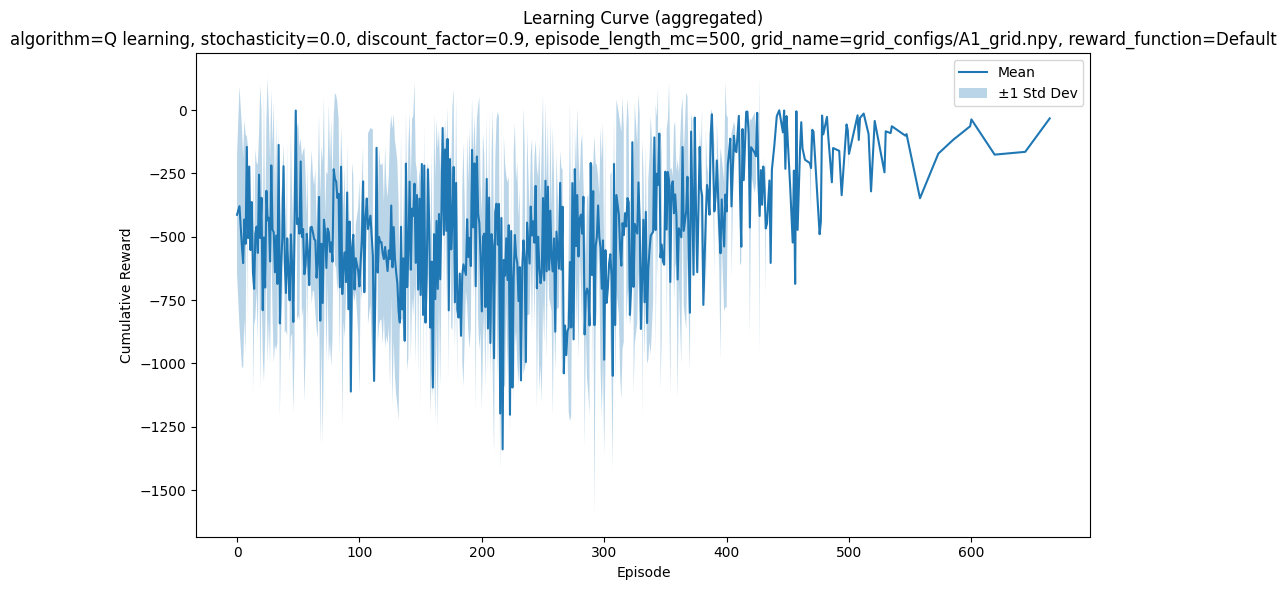

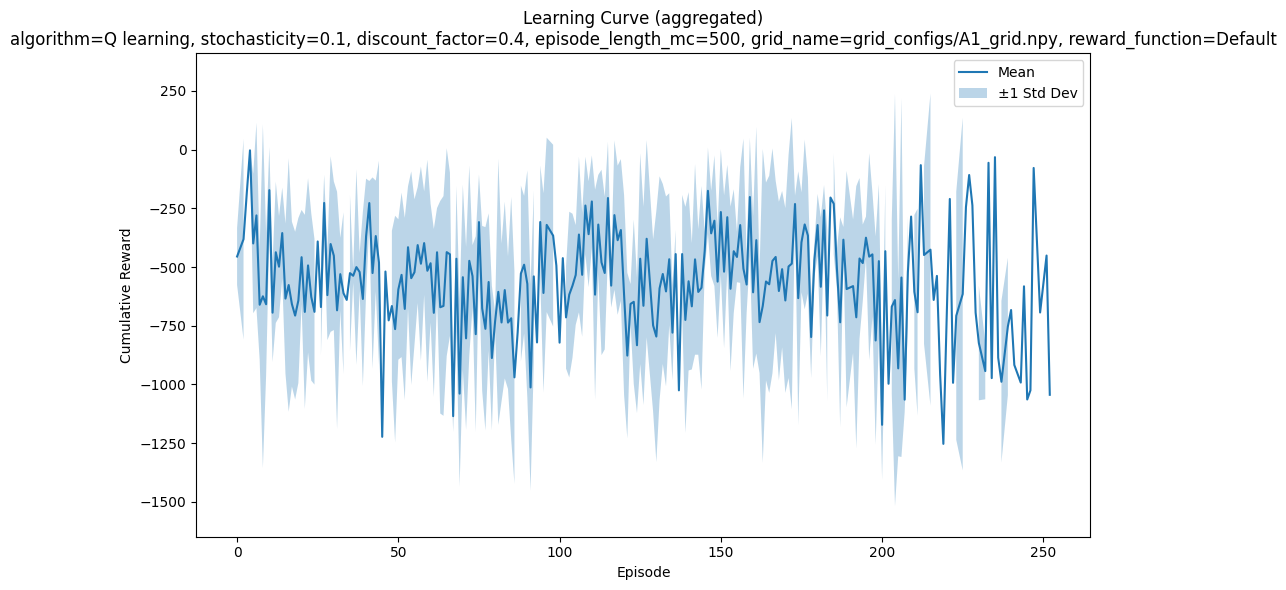

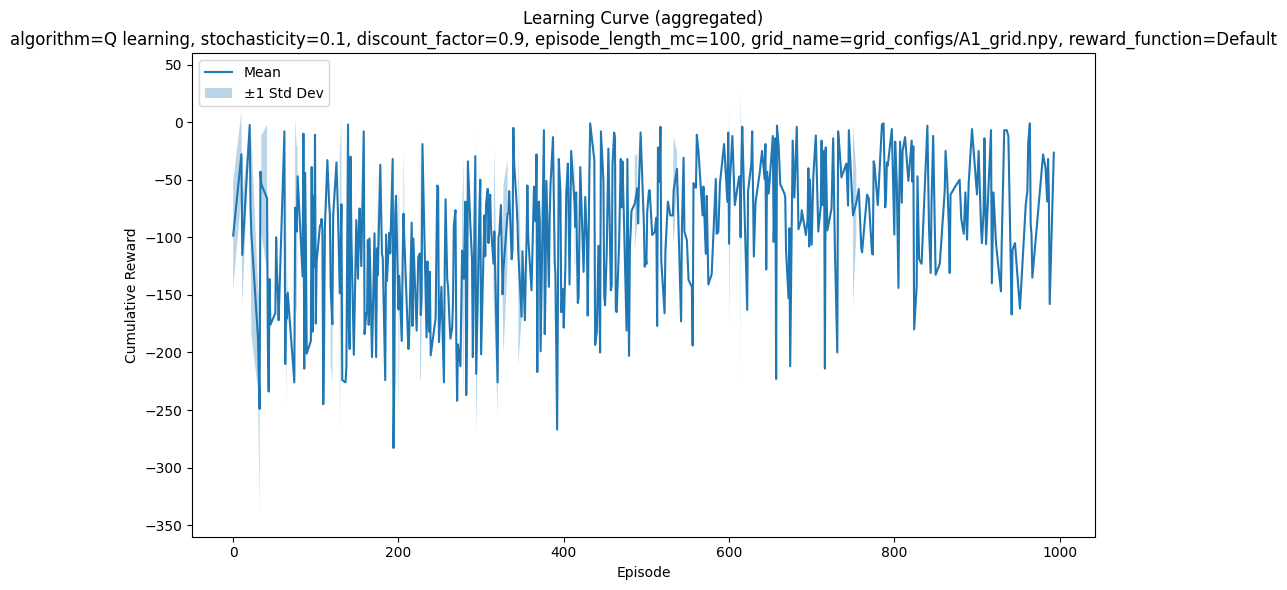

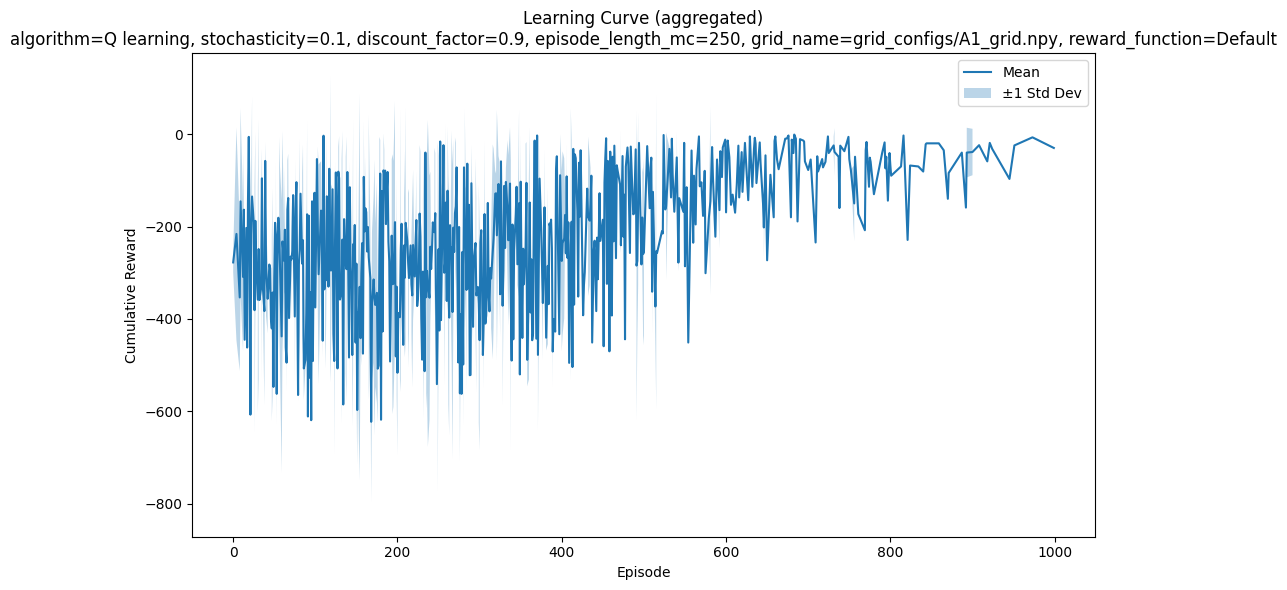

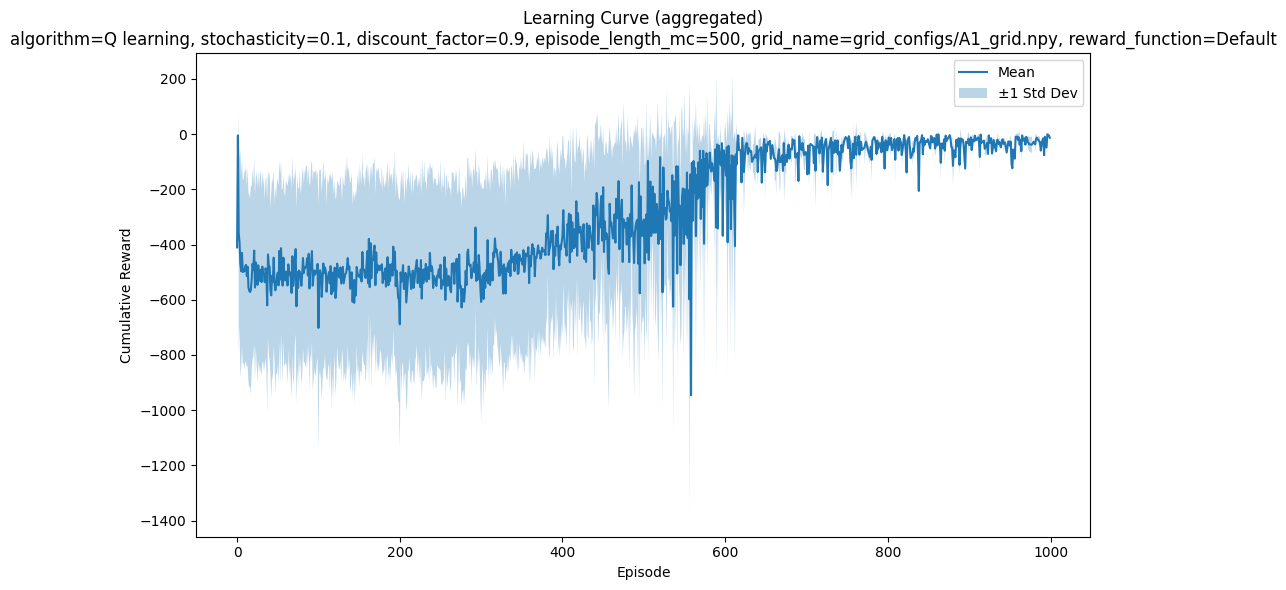

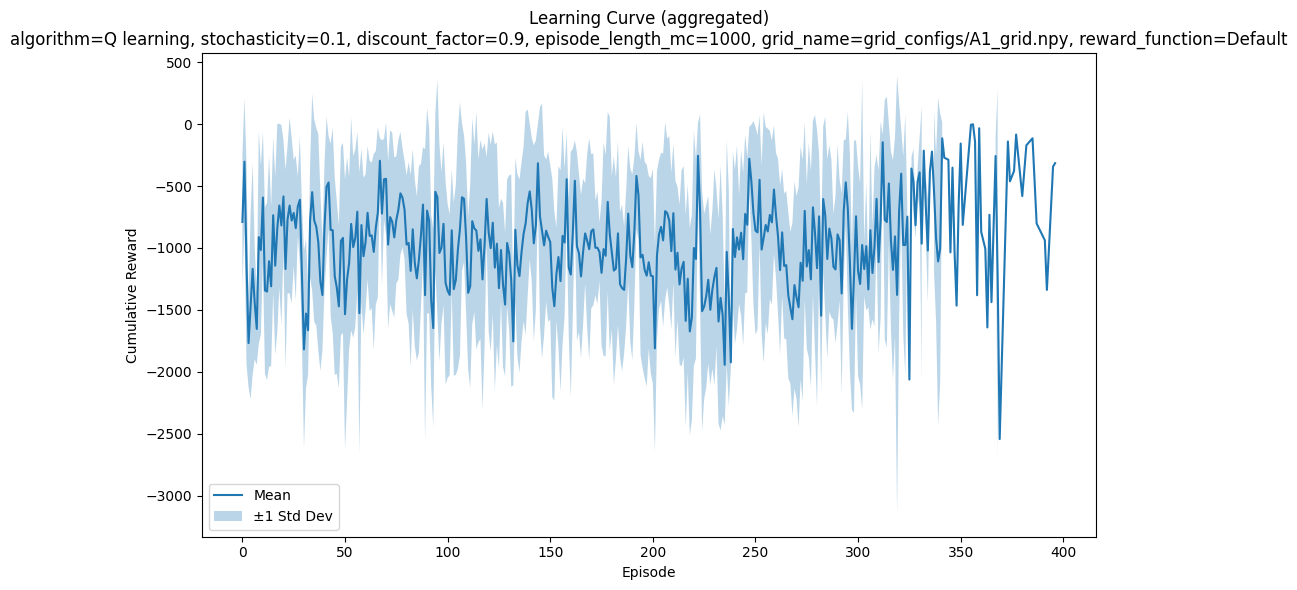

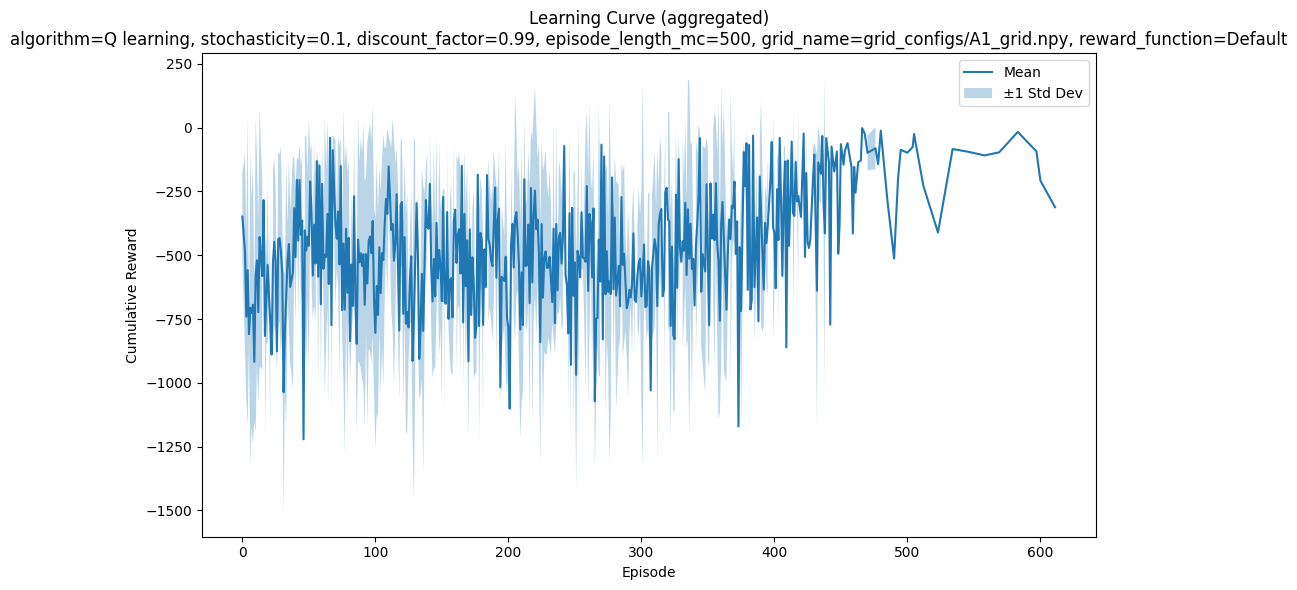

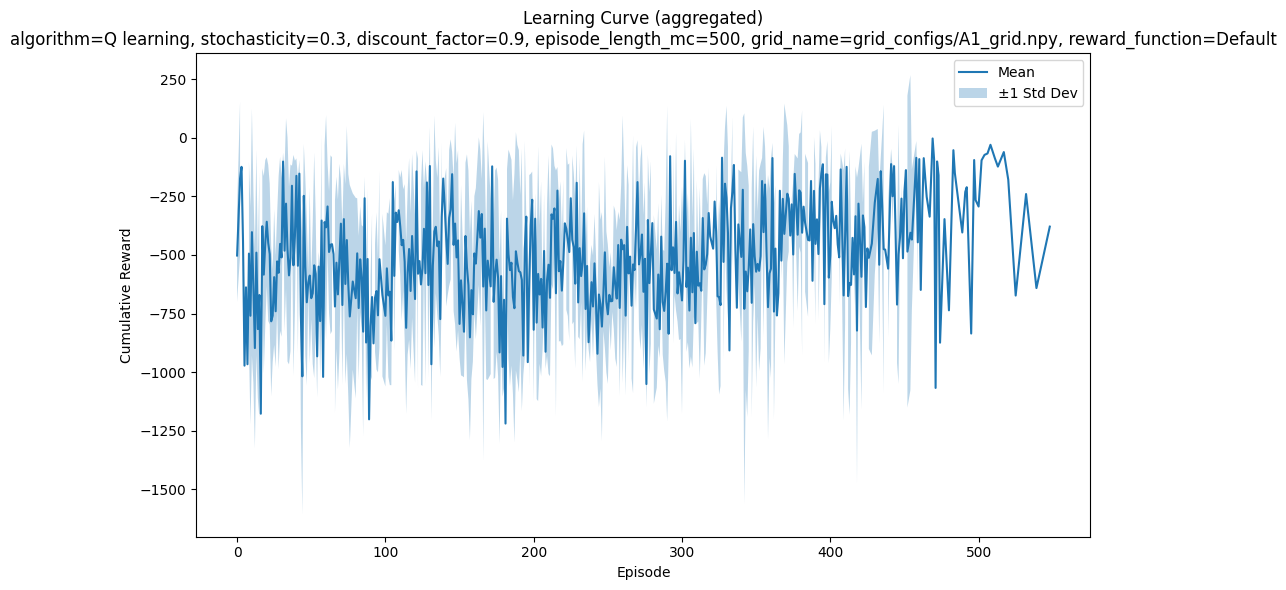

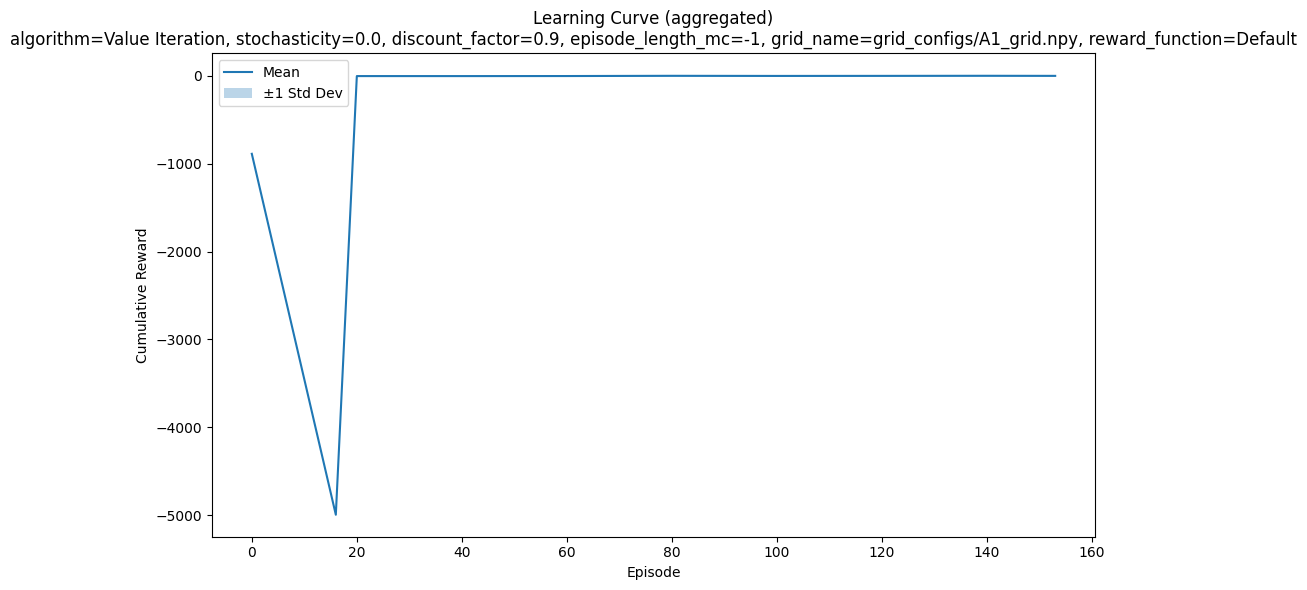

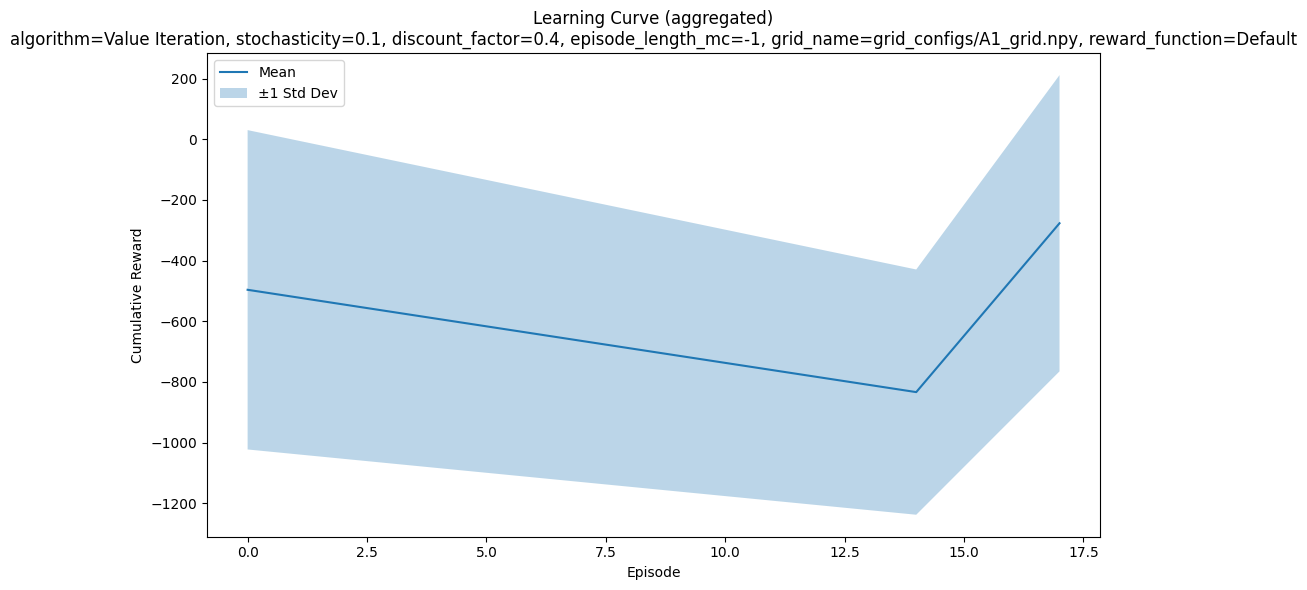

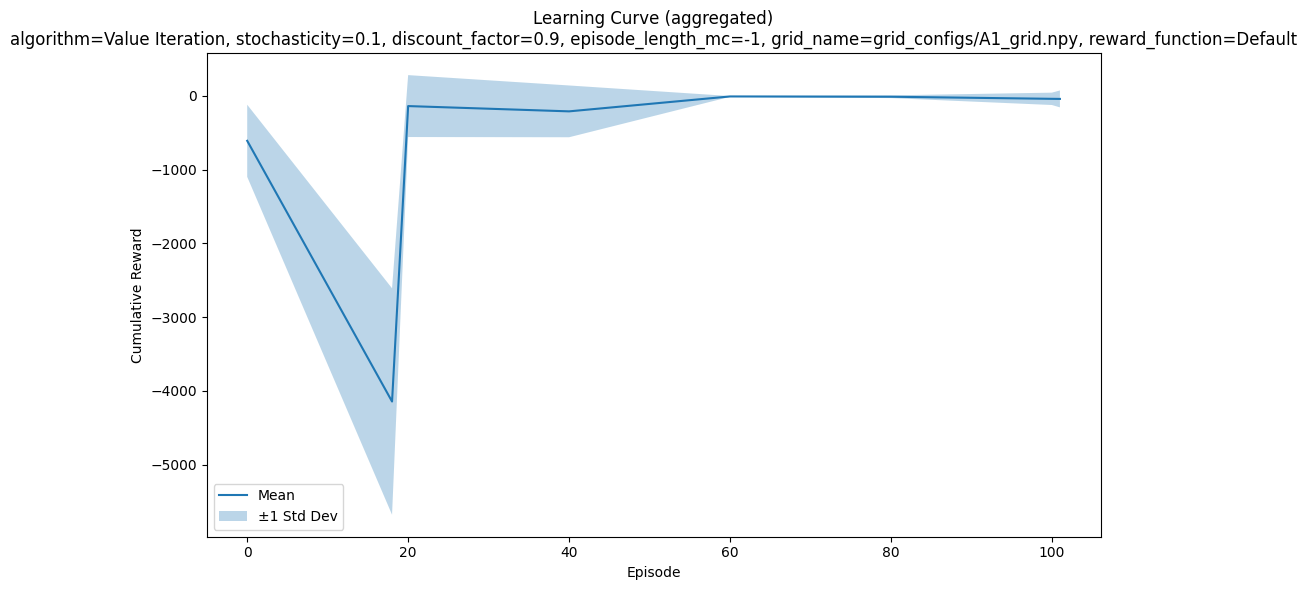

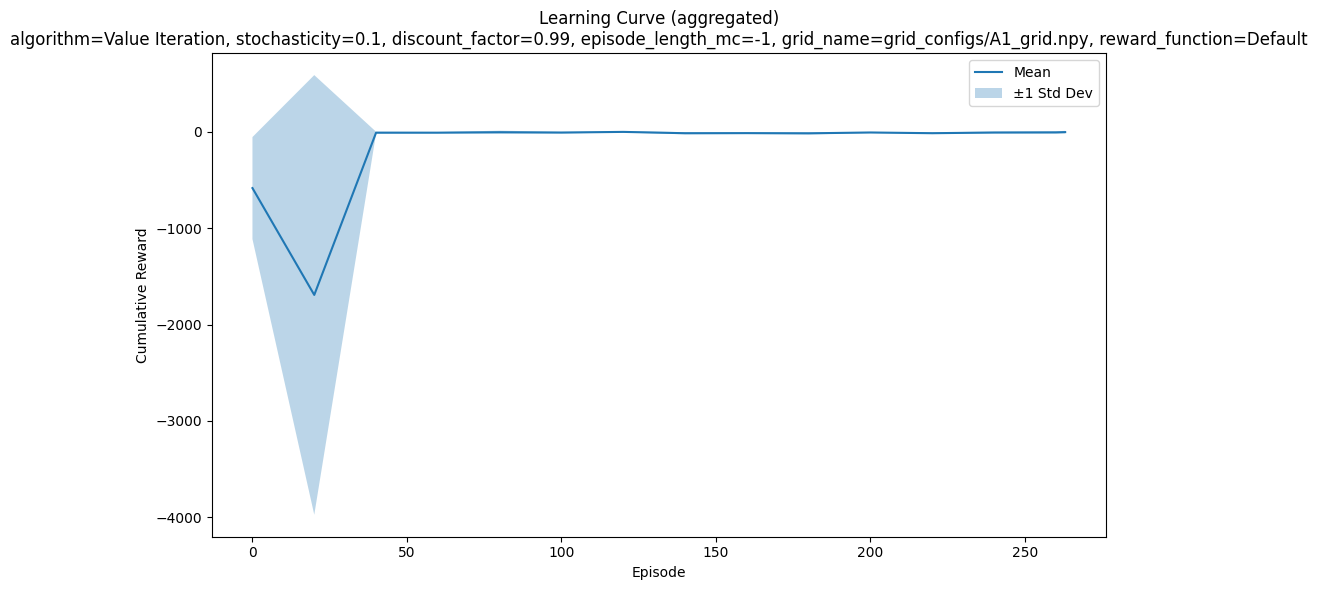

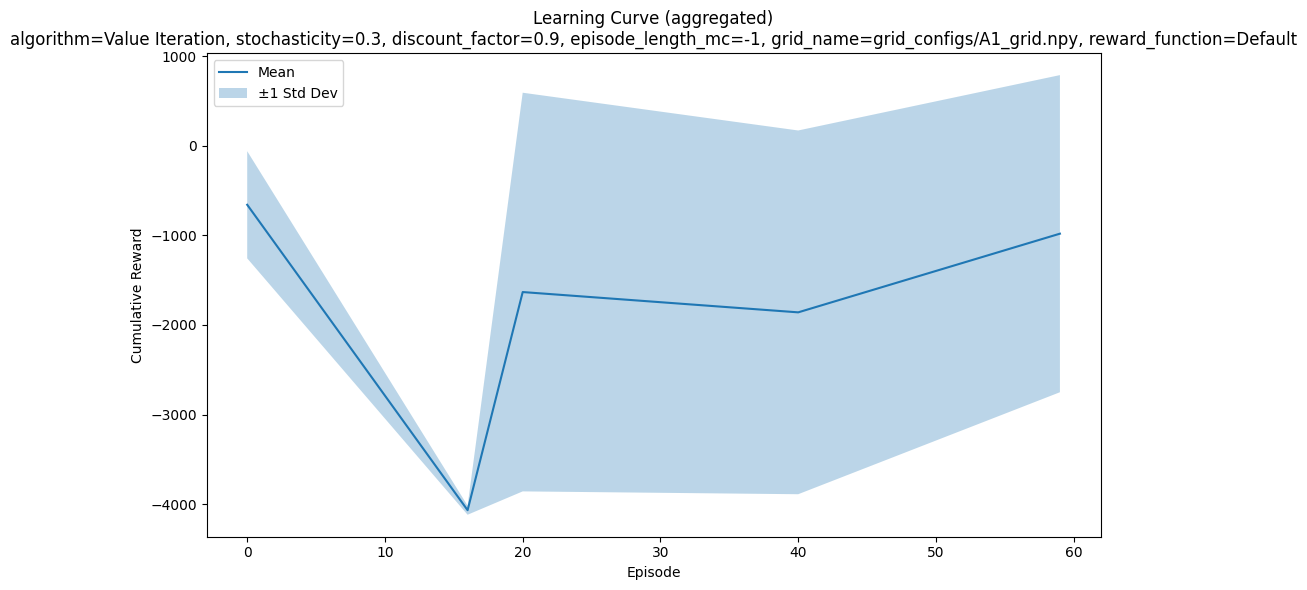

In [3]:
# Graph generated using ChatGPT:
# https://chatgpt.com/share/681dc499-9e24-8001-93b2-1d11e7a01f58

# 3) Aggregate: only group on the *static* hyper‑params, not on epsilon
param_cols = [
    'algorithm',
    'stochasticity',
    'discount_factor',
    'episode_length_mc',
    'grid_name',
    'reward_function'
]

agg_plots = {}
for params, grp in df.groupby(param_cols):
    # pivot: index=episode, columns=run_id, values=cumulative_reward
    wide = grp.pivot_table(
        index='episode',
        columns='run_id',
        values='cumulative_reward'
    ).sort_index()

    # skip any tiny groups just in case
    if wide.shape[1] < 2:
        continue

    agg_plots[params] = wide

# 4) Plot mean ± std for each parameter‑set
for params, wide in agg_plots.items():
    mean_series = wide.mean(axis=1)
    std_series  = wide.std(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_series.index, mean_series, label='Mean')
    plt.fill_between(
        mean_series.index,
        mean_series - std_series,
        mean_series + std_series,
        alpha=0.3,
        label='±1 Std Dev'
    )

    param_str = ', '.join(f'{k}={v}' for k, v in zip(param_cols, params))
    plt.title(f'Learning Curve (aggregated)\n{param_str}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [4]:
# deduce the standard values for the hyper-parameters
stable_parameters = [
    'stochasticity',
    'discount_factor',
    'episode_length_mc',
]

variable_parameters = [
    'learning_rate',
    'epsilon',
]

# the default values for the hyper-parameters
for param in stable_parameters:
    default_value = df[param].mode()[0]
    print(f"{param}: {default_value}")

for param in variable_parameters:
    default_value = df[param].mode()[0]
    print(f"{param}: {default_value}")

stochasticity: 0.1
discount_factor: 0.9
episode_length_mc: 500
learning_rate: 0.1
epsilon: 1.0


In [5]:
df['stochasticity'].unique()

array([0. , 0.1, 0.3])

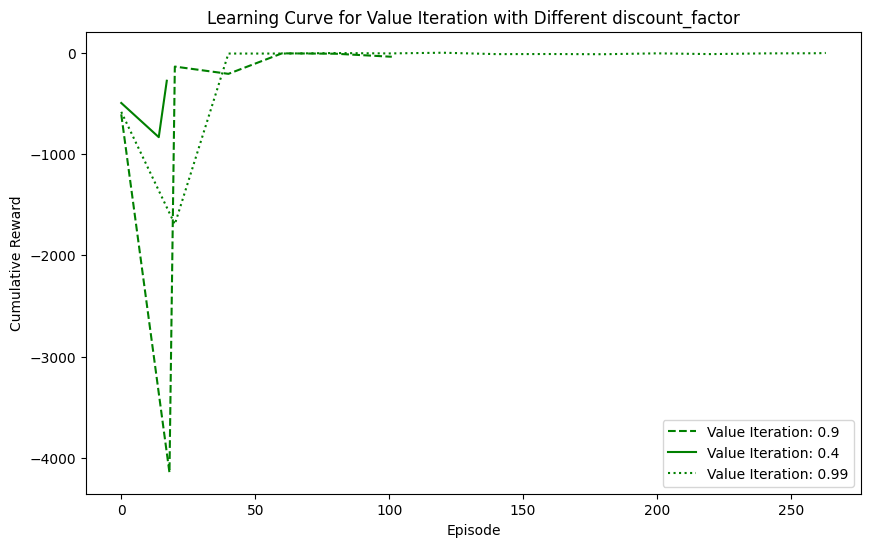

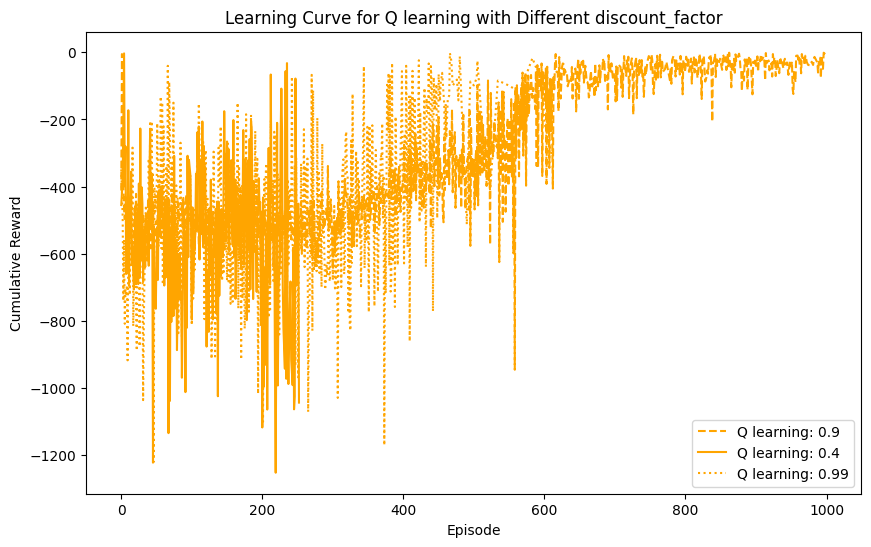

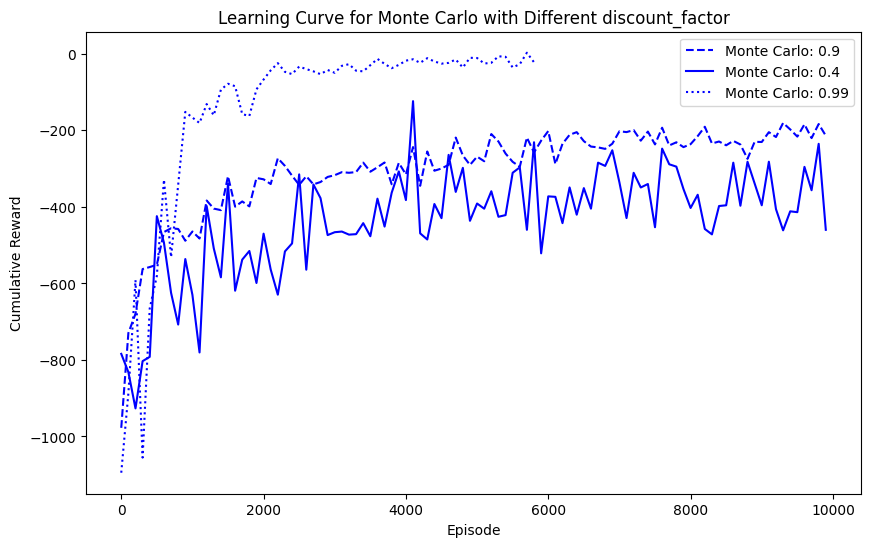

In [6]:
parameter = 'discount_factor'  # or 'stochasticity'

# create a map from algorithm to its corresponding color
colors = {
    'Value Iteration': 'green',
    'Monte Carlo': 'blue',
    'Q learning': 'orange'
}

# and from stochasticity to a line style
line_styles = {
    '0.0': '-', 
    '0.1': '--',
    '0.3': ':',
    '0.4': '-',
    '0.9': '--',
    '0.99': ':',
}



for algorithm in df['algorithm'].unique():
    plt.figure(figsize=(10, 6))
    for param_value in df[parameter].unique():
        # filter the dataframe for the current algorithm and parameter value, while keeping all other parameters equal to their default values
        filtered_df = df[
            (df['algorithm'] == algorithm) &
            (df[parameter] == param_value)
        ]
        # filter out the default values for the other parameters
        for param in stable_parameters:
            if param != parameter:
                default_value = df[param].mode()[0]
                filtered_df = filtered_df[
                    (filtered_df[param] == default_value) |
                    (filtered_df[param] == -1)
                    ]
        # check if the filtered dataframe is empty
        if filtered_df.empty:
            print(f"No data for {algorithm} with {parameter}={param_value}")
            continue

        # plot the mean and std deviation over the runs
        mean_series = filtered_df.groupby('episode')['cumulative_reward'].mean()
        std_series = filtered_df.groupby('episode')['cumulative_reward'].std()
        plt.plot(mean_series.index, mean_series, label=f'{algorithm}: {param_value}', color=colors[algorithm], linestyle=line_styles[str(param_value)])
        # plt.fill_between(
        #     mean_series.index,
        #     mean_series - std_series,
        #     mean_series + std_series,
        #     alpha=0.3,
        #     color=colors[algorithm],
        # )
        plt.title(f'Learning Curve for {algorithm} with Different {parameter}')

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Learning Curve for {algorithm} with Different {parameter}')
    plt.legend()
    plt.show()
